# Combain weather data

In [22]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#py lib
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.dates as mdates


In [18]:
austin = pd.read_csv('15minute_data_austin.csv')
initial_data = pd.read_csv('15minute_data_austin.csv')

# only looking at device 661
data661 = initial_data.loc[initial_data['dataid'] == 661]
#
data661['local_15min'] = data661['local_15min'].str[:-3]
data661['local_15min'] = pd.to_datetime(data661['local_15min'])
data661 = data661.dropna(axis=1, how='all')

data661 = data661[['local_15min', 'grid', 'solar', 'leg1v', 'leg2v']]
data661 = data661.sort_values(by="local_15min")
data661 = data661[data661['solar'].notna()]
data661.tail(n=5)

/tmp/ipykernel_13992/1312505678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data661['local_15min'] = data661['local_15min'].str[:-3]
/tmp/ipykernel_13992/1312505678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data661['local_15min'] = pd.to_datetime(data661['local_15min'])


,local_15min,grid,solar,leg1v,leg2v
35027,2018-12-31 22:45:00,1.497,-0.014,122.584,122.813
35028,2018-12-31 23:00:00,1.747,-0.014,122.534,122.799
35029,2018-12-31 23:15:00,1.440,-0.013,122.612,122.807
35030,2018-12-31 23:30:00,1.345,-0.012,122.465,122.911
35031,2018-12-31 23:45:00,1.291,-0.013,122.521,122.809


In [35]:
weather = pd.read_csv('weather.csv')
weather.head(n=5)
weather['localhour'] = pd.to_datetime(weather['localhour'])
weather = weather.loc[(weather['localhour'] >= datetime(2018, 1, 1)) & (weather['localhour'] <= datetime(2018, 12, 31))]
weather.head(n=5)

,localhour,latitude,longitude,tz_offset,summary,ozone,ozone_error,temperature,temperature_error,dew_point,...,wind_speed_error,cloud_cover,cloud_cover_error,wind_bearing,precip_intensity,precip_intensity_error,precip_probability,precip_type,irradiance,location
162207,2018-01-19 00:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,354.91,NaN,38.35,NaN,21.67,...,NaN,0.82,NaN,177.0,0.0,NaN,0.0,NaN,NaN,NaN
162208,2018-01-19 01:00:00,30.292432,-97.699662,-6.0,Overcast,353.04,NaN,38.79,NaN,22.10,...,NaN,0.97,NaN,176.0,0.0,NaN,0.0,NaN,NaN,NaN
162209,2018-01-19 02:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,350.21,NaN,38.80,NaN,22.80,...,NaN,0.84,NaN,182.0,0.0,NaN,0.0,NaN,NaN,NaN
162210,2018-01-19 03:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,347.48,NaN,39.14,NaN,23.34,...,NaN,0.89,NaN,183.0,0.0,NaN,0.0,NaN,NaN,NaN
162211,2018-01-19 04:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,344.96,NaN,39.38,NaN,23.93,...,NaN,0.84,NaN,175.0,0.0,NaN,0.0,NaN,NaN,NaN


In [61]:
for index, value in enumerate(weather['localhour']):
    weather['localhour'].iloc[index] = value - pd.Timedelta(hours=1)
weather.head(n = 5)

/home/yunrui/miniconda3/envs/thesis1/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,localhour,latitude,longitude,tz_offset,summary,ozone,ozone_error,temperature,temperature_error,dew_point,...,wind_speed_error,cloud_cover,cloud_cover_error,wind_bearing,precip_intensity,precip_intensity_error,precip_probability,precip_type,irradiance,location
162207,2018-01-18 23:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,354.91,NaN,38.35,NaN,21.67,...,NaN,0.82,NaN,177.0,0.0,NaN,0.0,NaN,NaN,NaN
162208,2018-01-19 00:00:00,30.292432,-97.699662,-6.0,Overcast,353.04,NaN,38.79,NaN,22.10,...,NaN,0.97,NaN,176.0,0.0,NaN,0.0,NaN,NaN,NaN
162209,2018-01-19 01:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,350.21,NaN,38.80,NaN,22.80,...,NaN,0.84,NaN,182.0,0.0,NaN,0.0,NaN,NaN,NaN
162210,2018-01-19 02:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,347.48,NaN,39.14,NaN,23.34,...,NaN,0.89,NaN,183.0,0.0,NaN,0.0,NaN,NaN,NaN
162211,2018-01-19 03:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,344.96,NaN,39.38,NaN,23.93,...,NaN,0.84,NaN,175.0,0.0,NaN,0.0,NaN,NaN,NaN


In [63]:

weather = weather.loc[weather['latitude'] == 30.292432]
weather = weather.sort_values(by="localhour")
weather.head(n = 5)

,localhour,latitude,longitude,tz_offset,summary,ozone,ozone_error,temperature,temperature_error,dew_point,...,wind_speed_error,cloud_cover,cloud_cover_error,wind_bearing,precip_intensity,precip_intensity_error,precip_probability,precip_type,irradiance,location
163362,2017-12-31 23:00:00,30.292432,-97.699662,-6.0,Overcast,294.04,NaN,25.82,NaN,22.30,...,NaN,0.96,NaN,1.0,0.0,NaN,0.0,NaN,NaN,NaN
163363,2018-01-01 00:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,293.88,NaN,25.25,NaN,20.71,...,NaN,0.68,NaN,3.0,0.0,NaN,0.0,NaN,NaN,NaN
163364,2018-01-01 01:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,294.27,NaN,25.00,NaN,19.40,...,NaN,0.68,NaN,6.0,0.0,NaN,0.0,NaN,NaN,NaN
163365,2018-01-01 02:00:00,30.292432,-97.699662,-6.0,Mostly Cloudy,294.83,NaN,24.97,NaN,18.27,...,NaN,0.91,NaN,2.0,0.0,NaN,0.0,NaN,NaN,NaN
163366,2018-01-01 03:00:00,30.292432,-97.699662,-6.0,Overcast,295.59,NaN,24.93,NaN,17.43,...,NaN,1.00,NaN,7.0,0.0,NaN,0.0,NaN,NaN,NaN


In [64]:
# only take those first
to_combain = weather[['localhour', 'summary', 'temperature', 'cloud_cover']]
to_combain.head(n=5)

,localhour,summary,temperature,cloud_cover
163362,2017-12-31 23:00:00,Overcast,25.82,0.96
163363,2018-01-01 00:00:00,Mostly Cloudy,25.25,0.68
163364,2018-01-01 01:00:00,Mostly Cloudy,25.00,0.68
163365,2018-01-01 02:00:00,Mostly Cloudy,24.97,0.91
163366,2018-01-01 03:00:00,Overcast,24.93,1.00


In [65]:
# check if missing value
to_combain['cloud_cover'].isnull().values.any()
to_combain.shape


(9044, 4)

# Combian with the solar data

    I down sacle the data from 15 min to 1hr and join the two tables

In [66]:
merged = pd.merge(left=data661, right= to_combain, left_on='local_15min', right_on='localhour')
merged.head(n = 5)
merged.shape


(8958, 9)

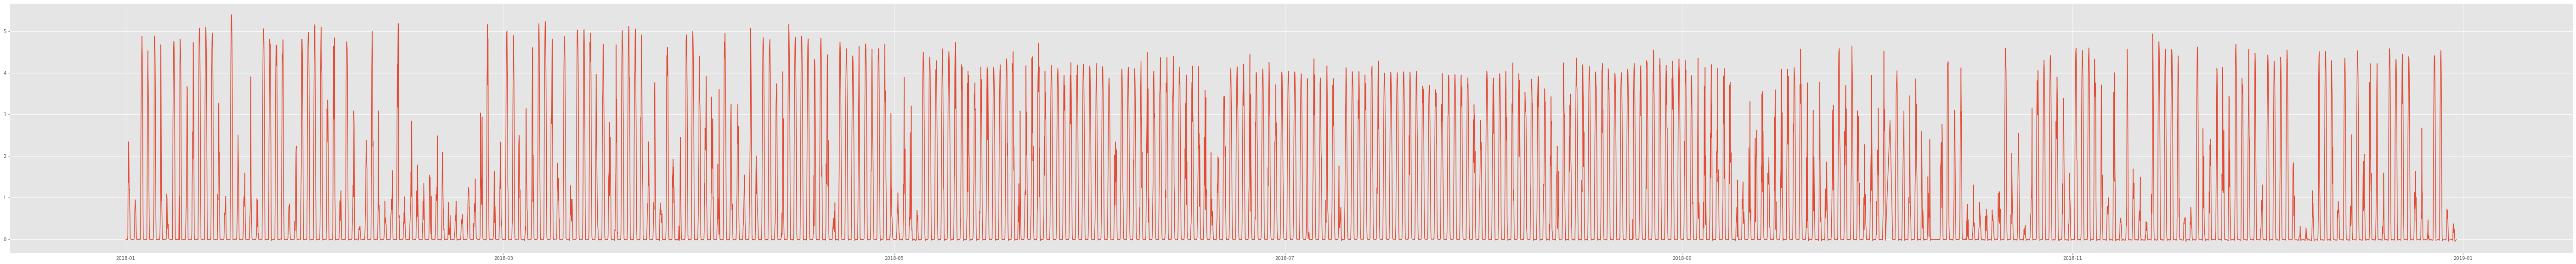

False

In [67]:
from matplotlib.pyplot import figure
xpoints = merged['local_15min']
ypoints = merged['solar']
figure(figsize=(100, 10))
plt.plot(xpoints, ypoints)

plt.show()
merged['solar'].isnull().values.any()

In [68]:
merged['local_15min'][1] - merged['local_15min'][0] == pd.Timedelta("1 hour")

True

In [71]:
#count = 0

#for index, obj in enumerate(merged['local_15min']):
    #if index == 8958:
     #   continue
    #if merged['local_15min'][index + 1] - obj != pd.Timedelta("1 hour"):
    #    count += 1
        
        
#print(count)
merged = merged.drop('localhour', 1)
merged.to_csv('merged_new.csv', index = False)

/tmp/ipykernel_13992/1626369406.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merged = merged.drop('localhour', 1)


In [72]:
merged['local_15min'] = pd.to_datetime(merged['local_15min']).dt.time


In [73]:
merged.head(n=5)

,local_15min,grid,solar,leg1v,leg2v,summary,temperature,cloud_cover
0,01:00:00,1.447,-0.002,NaN,NaN,Mostly Cloudy,25.00,0.68
1,02:00:00,1.095,-0.006,122.862,123.546,Mostly Cloudy,24.97,0.91
2,03:00:00,1.381,-0.005,122.780,123.529,Overcast,24.93,1.00
3,04:00:00,0.812,-0.005,122.654,123.233,Overcast,24.84,0.94
4,05:00:00,0.498,-0.005,122.594,123.032,Overcast,24.69,0.98


In [74]:
from datetime import time
merged = merged.loc[merged['local_15min'] == time(13)]

In [75]:
merged.shape

(372, 8)

In [76]:
merged.head(n=5)

,local_15min,grid,solar,leg1v,leg2v,summary,temperature,cloud_cover
12,13:00:00,0.522,1.184,122.669,122.915,Overcast,29.01,1.00
36,13:00:00,-0.208,0.795,122.534,122.942,Overcast,30.51,0.94
60,13:00:00,-4.295,4.880,123.646,124.205,Clear,51.41,0.03
84,13:00:00,-2.894,3.466,123.361,123.779,Clear,53.91,0.03
108,13:00:00,-4.349,4.843,124.409,124.967,Clear,59.43,0.04


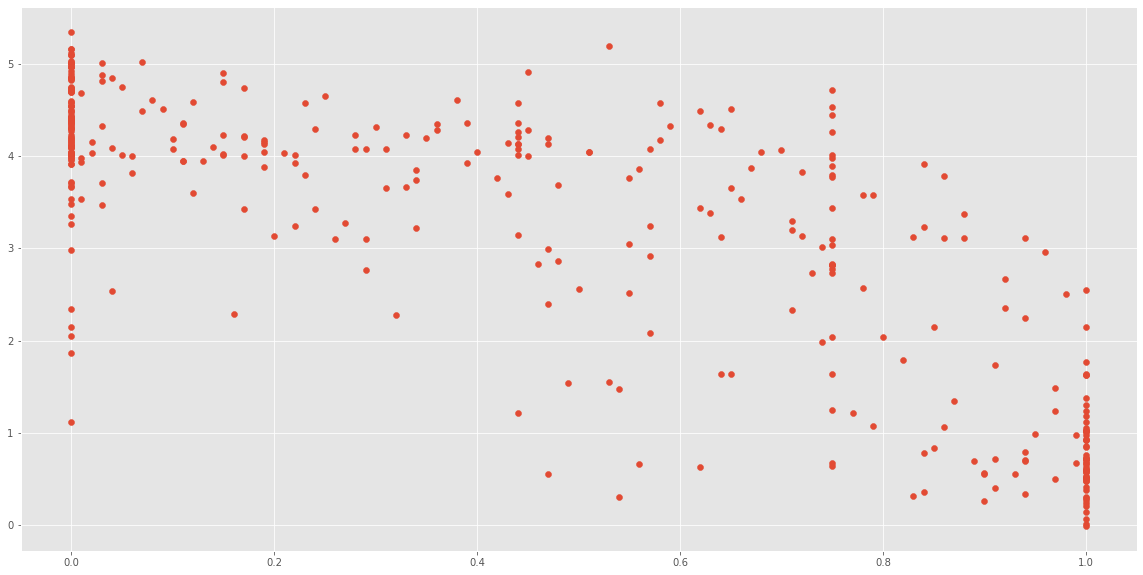

False

In [77]:
from matplotlib.pyplot import figure
xpoints = merged['cloud_cover']
ypoints = merged['solar']
figure(figsize=(20, 10))
plt.scatter(xpoints, ypoints)

plt.show()
merged['solar'].isnull().values.any()